In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
trained_model = tf.keras.models.load_model("./saved_cnn/my_model")

In [ ]:
trained_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 8)         224       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_3   (None, 16)               0   

In [ ]:
IMAGES_DIR = "../images/"

In [ ]:
# Load data
response_and_filenames = pd.read_csv(
    "../clean/cleaned_data/cnn_modeling_data.csv"
)

# Append directory to filenames
response_and_filenames["Filename"] = response_and_filenames["Filename"].apply(
    lambda x: IMAGES_DIR + x
).astype(str)

# Partition data
train, test = train_test_split(response_and_filenames, train_size=0.8, shuffle=True, random_state=1)

In [ ]:
# Data Augmentation
def augment(x):
  x = tf.image.random_flip_left_right(x)
  x = tf.image.random_flip_up_down(x)
  x = tf.keras.preprocessing.image.random_shear(x, 7)
  return x

In [ ]:
# Normalize RGB data, denote validation split
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=augment,
    rescale=1./255,
    validation_split=0.2
)

# Normalize RGB data
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Preprocessing
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col="Filename",
    y_col="chl",
    target_size=(64,64),
    color_mode="rgb",
    class_mode="raw",  # regression
    batch_size=64,
    shuffle=True,
    seed=2,
    subset="training",
)

validate_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col="Filename",
    y_col="chl",
    target_size=(64,64),
    color_mode="rgb",
    class_mode="raw",
    batch_size=64,
    shuffle=True,
    seed=2,
    subset="validation",
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col="Filename",
    y_col="chl",
    target_size=(64,64),
    color_mode="rgb",
    class_mode="raw",
    batch_size=64,
    shuffle=False
)

Found 759 validated image filenames.
Found 189 validated image filenames.
Found 238 validated image filenames.


In [ ]:
# Construct model architecture
inputs = tf.keras.Input(shape=(64, 64, 3))
x = tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation="relu")(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(
    optimizer="adam",
    loss="mse"
)

# Train model
history = model.fit(
    train_images,
    validation_data=validate_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
12/12 [==============================] - 36s 3s/step - loss: 1.6647 - val_loss: 1.5528
Epoch 2/100
12/12 [==============================] - 35s 3s/step - loss: 1.5772 - val_loss: 1.5396
Epoch 3/100
12/12 [==============================] - 42s 4s/step - loss: 1.5301 - val_loss: 1.4999
Epoch 4/100
12/12 [==============================] - 36s 3s/step - loss: 1.4940 - val_loss: 1.4582
Epoch 5/100
12/12 [==============================] - 36s 3s/step - loss: 1.4601 - val_loss: 1.4290
Epoch 6/100
12/12 [==============================] - 35s 3s/step - loss: 1.4353 - val_loss: 1.4085
Epoch 7/100
12/12 [==============================] - 36s 3s/step - loss: 1.2992 - val_loss: 1.2943
Epoch 8/100
12/12 [==============================] - 31s 3s/step - loss: 1.1870 - val_loss: 1.2697
Epoch 9/100
12/12 [==============================] - 31s 3s/step - loss: 1.1705 - val_loss: 1.1336
Epoch 10/100
12/12 [==============================] - 35s 3s/step - loss: 1.0253 - val_loss: 0.9311
Epoch 11/

In [ ]:
# Predict with test data
pred = np.squeeze(trained_model.predict(test_images))
y = test_images.labels

# Performance Metrics
rmse = trained_model.evaluate(test_images, verbose=0)
print(f"Test RMSE:\t {rmse:.5f}")

mae = mean_absolute_error(y, pred)
print(f"Test MAE:\t {mae:.5f}")

r2 = r2_score(y, pred)
print(f"Test R2:\t {r2:.3f}")

4/4 [==============================] - 36s 12s/step
Test RMSE:	 0.44363
Test MAE:	 0.29212
Test R2:	 0.690


<ipython-input-19-1d8fc18413e7>:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


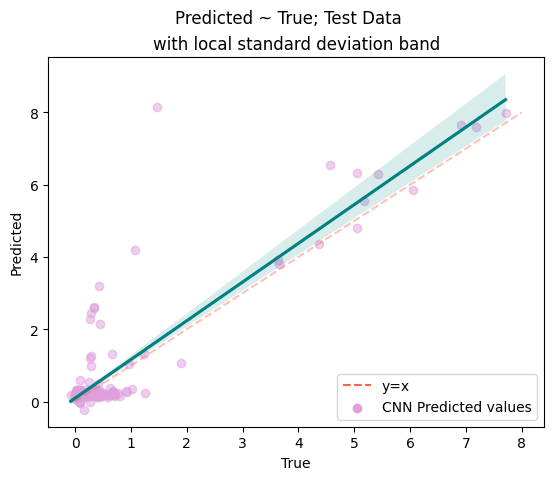

In [ ]:
# Performance graphic
import matplotlib.pyplot as plt
from seaborn import regplot

plt.plot(range(9), linestyle='--', c='tomato', alpha=0.4, label="y=x", )

regplot(
    x=y, 
    y=pred, 
    x_ci="sd",
    label="CNN Predicted values", 
    color="teal", 
    scatter_kws={"alpha": 0.5, "color": "plum"}
)

plt.suptitle("Predicted ~ True; Test Data")
plt.title("with local standard deviation band", )
plt.ylabel("Predicted")
plt.xlabel("True")
leg = plt.legend(loc="lower right")
for lh in leg.legendHandles:
  lh.set_alpha(1);
plt.savefig("./plots/CNN_pred_vs_true_test_data.png")

In [ ]:
!mkdir -p saved_model
model.save('saved_CNN/my_model');

In [ ]:
# Prepare training images without augmentation
test_train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test_train_images = test_train_generator.flow_from_dataframe(
    dataframe=train,
    x_col="Filename",
    y_col="chl",
    target_size=(64,64),
    color_mode="rgb",
    class_mode="raw",
    batch_size=64,
    shuffle=False
)

# Predict with test data
train_pred = np.squeeze(trained_model.predict(test_train_images))
train_y = test_train_images.labels

# Performance Metrics
train_rmse = trained_model.evaluate(test_train_images, verbose=0)
print(f"Train RMSE:\t {train_rmse:.5f}")

train_mae = mean_absolute_error(train_y, train_pred)
print(f"Train MAE:\t {train_mae:.5f}")

train_r2 = r2_score(train_y, train_pred)
print(f"Train R2:\t {train_r2:.3f}")


Found 948 validated image filenames.
15/15 [==============================] - 3s 194ms/step
Train RMSE:	 0.28448
Train MAE:	 0.25410
Train R2:	 0.812


<ipython-input-14-410005e725c5>:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


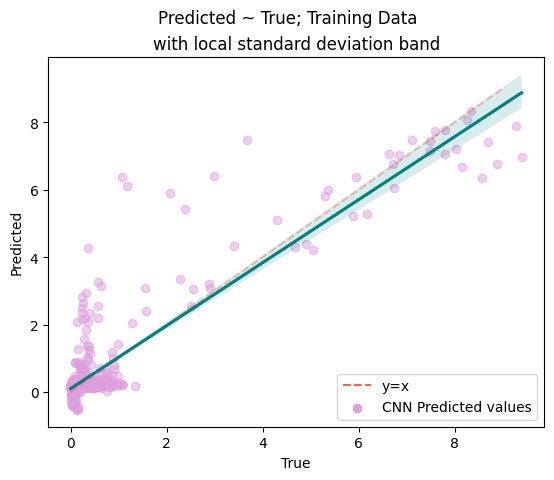

In [ ]:

# Performance graphic
import matplotlib.pyplot as plt
from seaborn import regplot

plt.plot(range(10), linestyle='--', c='tomato', alpha=0.4, label="y=x", )

regplot(
    x=train_y, 
    y=train_pred, 
    x_ci="sd",
    label="CNN Predicted values", 
    color="teal", 
    scatter_kws={"alpha": 0.5, "color": "plum"}
)

plt.suptitle("Predicted ~ True; Training Data")
plt.title("with local standard deviation band", )
plt.ylabel("Predicted")
plt.xlabel("True")
leg = plt.legend(loc="lower right")
for lh in leg.legendHandles:
  lh.set_alpha(1)
plt.savefig("./plots/CNN_pred_vs_true_training_data.png")